In [1]:
# nobody knows anything
#                  -Kai
#
# github.com/kaibrooks

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
import sys
import io
import os
import matplotlib.pyplot as plt # fancy plots
from datetime import datetime # so we know how much time we've wasted

print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
#print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
#print('Pillow version', PIL.__version__) 

Using TensorFlow backend.


TensorFlow version 2.0.0
Keras version 2.2.4-tf
Numpy version 1.17.4


In [16]:
# doin thangs
epochs=20 #60
epochOutput = False
diversity = [0.2, 0.5, 1.0, 1.2]


np.seterr(divide='ignore') # ignore divide by zero warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
## get text file

#path = get_file( # use this for http request
#    'afile.txt',
#    origin='http://omega.lul/afile.txt')

path = 'data/lotr1.txt'

with open(path, encoding='utf-8', errors='ignore') as f: # errors=ignore strips non utf-8 chars
    text = f.read().lower()
print('corpus length:', len(text))

corpus length: 969555


In [7]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorizing...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('Done')

total chars: 53
nb sequences: 323172
Vectorizing...
Done


In [8]:
# model
print('Building model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Done')

Building model...
Done


In [9]:
# train me

now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S"), 'UTC') # lets see how long this takes

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    if epochOutput:
        # print text at each epoch
        print()
        print('**************************** Generating text after Epoch: %d ****************************' % epoch)

        start_index = random.randint(0, len(text) - maxlen - 1)
        for diversity in [diversity]:
            print('--------------- diversity: ', diversity, '---------------')

            generated = ''
            sentence = text[start_index: start_index + maxlen]
            generated += sentence
            print('--------------- seed: <', sentence,'>')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char
                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 07-Dec-2019 01:29:39 UTC
Epoch 1/20
323172/323172 [==============================] - 245s 758us/step - loss: 1.7065
Epoch 2/20
323172/323172 [==============================] - 243s 753us/step - loss: 1.4360
Epoch 3/20
323172/323172 [==============================] - 245s 759us/step - loss: 1.3776
Epoch 4/20
323172/323172 [==============================] - 245s 758us/step - loss: 1.3437
Epoch 5/20
323172/323172 [==============================] - 2835s 9ms/step - loss: 1.3201
Epoch 6/20
323172/323172 [==============================] - 4209s 13ms/step - loss: 1.3088
Epoch 7/20
323172/323172 [==============================] - 240s 743us/step - loss: 1.2952
Epoch 8/20
323172/323172 [==============================] - 240s 744us/step - loss: 1.2860
Epoch 9/20
323172/323172 [==============================] - 244s 754us/step - loss: 1.2784
Epoch 10/20
323172/323172 [==============================] - 252s 781us/step - loss: 1.2706
Epoch 11/20
323172/323172 [=================

In [10]:
## save model log
# this is where you pay attention to where you mapped the Docker dir to your local dir at run

save_dir = os.path.join(os.getcwd(), 'trained_models')


if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes

# 
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel.h5'
summary_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# save model
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

#model_path = os.path.join(save_dir, summary_name)
#print(model_path)
#model.save(model_path)
  
print('Saved trained model at %s ' % os.path.join(save_dir, model_name)) 
print('Saved training summary at %s' % os.path.join(save_dir, summary_name))   

size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Model is',round(size/1e+6),'MB')

Saving...
Saved trained model at /tf/notebooks/trained_models/2019-12-07_01-29-39_trainedmodel.h5 
Saved training summary at /tf/notebooks/trained_models/2019-12-07_01-29-39_modelsummary.txt
Model is 1 MB


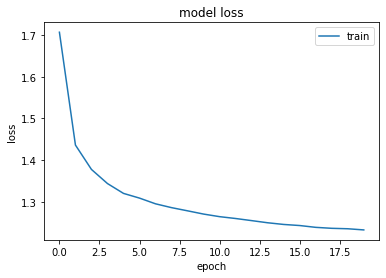

In [11]:
## plot accuracy
#plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='lower right')
#plt.show()

# plot history
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
## set for the final output
start_index = random.randint(0, len(text) - maxlen - 1)
sentence = text[start_index: start_index + maxlen]
randomizeOut = False
diversity = 0.5 # 0.5? depends on training length
maxChars = 1000 # 400 is same as above

if randomizeOut:
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

seed = sentence.replace('\n','')
seed = seed.replace('\t','')
print('*** seed: <', seed ,'>')
#sys.stdout.write(generated)

print('\n',seed, end = '')

for i in range(maxChars):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

*** seed: < c might not suddenly bring them to life  >

 c might not suddenly bring them to life to be and below the east many shout. and the night had seen will again with a leaves and the enemy. i must again to me: could want a made the words and strive as the sun had been many flowers, and far a shadow downs the shire was still and hunger and the things of the doors of the wind but the dark and fall like a white road that he came out of the world was some corrise of the trees. but it seemed to have inderiling a satt. the ring running through the ring they saw a great ring and spring to the shadow and slope and folk was a passage. there was a springs of the mountains and grew leaving began them a things of the shadows of his face of the man. 'you must be seen the wise that he had been trees the dark and the night of hills, and straight the enemy. every while they felt the roots of the shadow for the dark of his eyes reached the shadow of the road the land, and and the passage was liv